Summary:
- 

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from typing import Union
import warnings

warnings.filterwarnings('ignore')

sys.path.append("../utama_core/run/refiners/")
from filters import FIR_filter

NO_ROBOTS = 6
NO_ROWS = 1000  # Limit window to be analysed
X_AXES = np.arange(NO_ROWS)

CLEAN = "clean-raw.csv"
NOISY_G, FILT_G = "noisy-grsim-raw.csv", "noisy-grsim-filtered.csv"
NOISY_M, FILT_M = "noisy-manual-raw.csv", "noisy-manual-filtered.csv"

V_COL = "vector"
ID_COL, X_COL, Y_COL, TH_COL = "id", "x", "y", "orientation"
COLS = [X_COL, Y_COL, TH_COL]
COLS_ALL = COLS + [ID_COL]


def format_data(filename: str, id: bool = True) -> pd.DataFrame:  # for all 6 robots
    data = pd.read_csv(filename)
    if id:
        return data[COLS_ALL]
    return data[COLS].iloc[:NO_ROWS]

CLEAN_FD = format_data(CLEAN)
NOISY_G_FD, FILT_G_FD = format_data(NOISY_G), format_data(FILT_G)
NOISY_M_FD, FILT_M_FD = format_data(NOISY_M), format_data(FILT_M)


def extract_robot(data: pd.DataFrame, id: int) -> pd.DataFrame:
    return data[data[ID_COL]==id].iloc[:NO_ROWS].drop(ID_COL, axis=1).reset_index(drop=True)

def get_current_ax(axs: np.ndarray, id: int) -> plt.Axes:
    return axs[id//3][id%3]

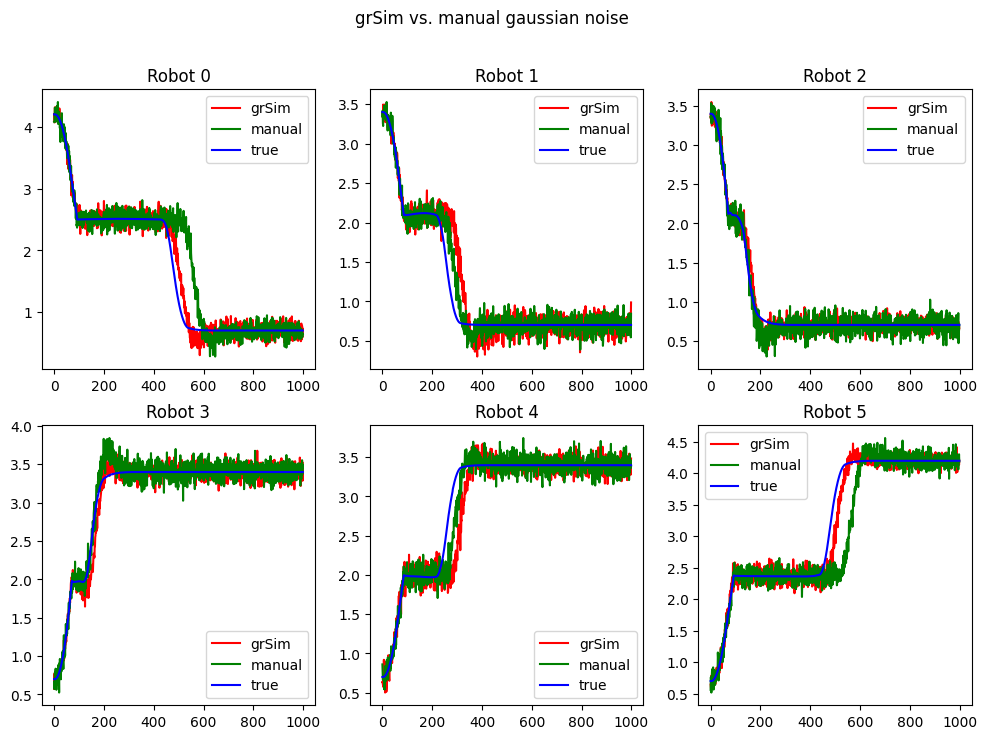

In [68]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("grSim vs. manual gaussian noise")

for id in range(NO_ROBOTS):
    clean = extract_robot(CLEAN_FD, id)
    noisy_g, noisy_m = extract_robot(NOISY_G_FD, id), extract_robot(NOISY_M_FD, id)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(X_AXES, noisy_g[X_COL], "r")
    current_ax.plot(X_AXES, noisy_m[X_COL], "g")
    current_ax.plot(X_AXES, clean[X_COL], "b")
    current_ax.legend(("grSim", "manual", "true"))

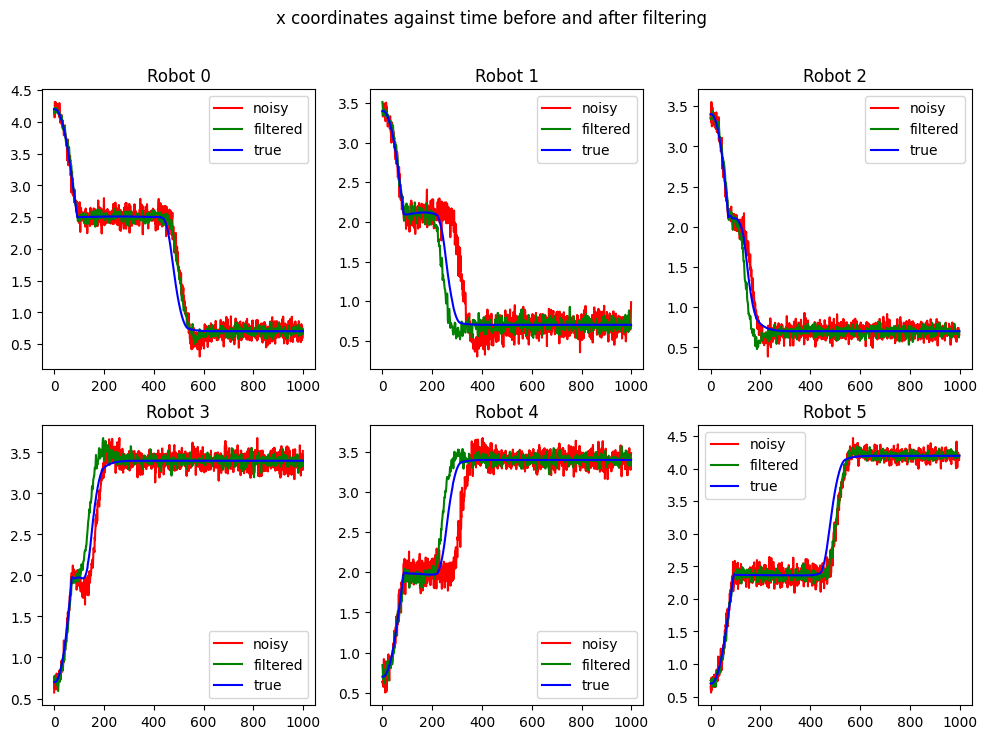

In [69]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("x coordinates against time before and after filtering")

for id in range(NO_ROBOTS):
    clean = extract_robot(CLEAN_FD, id)
    noisy_g, filt_g = extract_robot(NOISY_G_FD, id), extract_robot(FILT_G_FD, id)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(X_AXES, noisy_g[X_COL], "r")
    current_ax.plot(X_AXES, filt_g[X_COL], "g")
    current_ax.plot(X_AXES, clean[X_COL], "b")
    
    current_ax.legend(("noisy", "filtered", "true"))

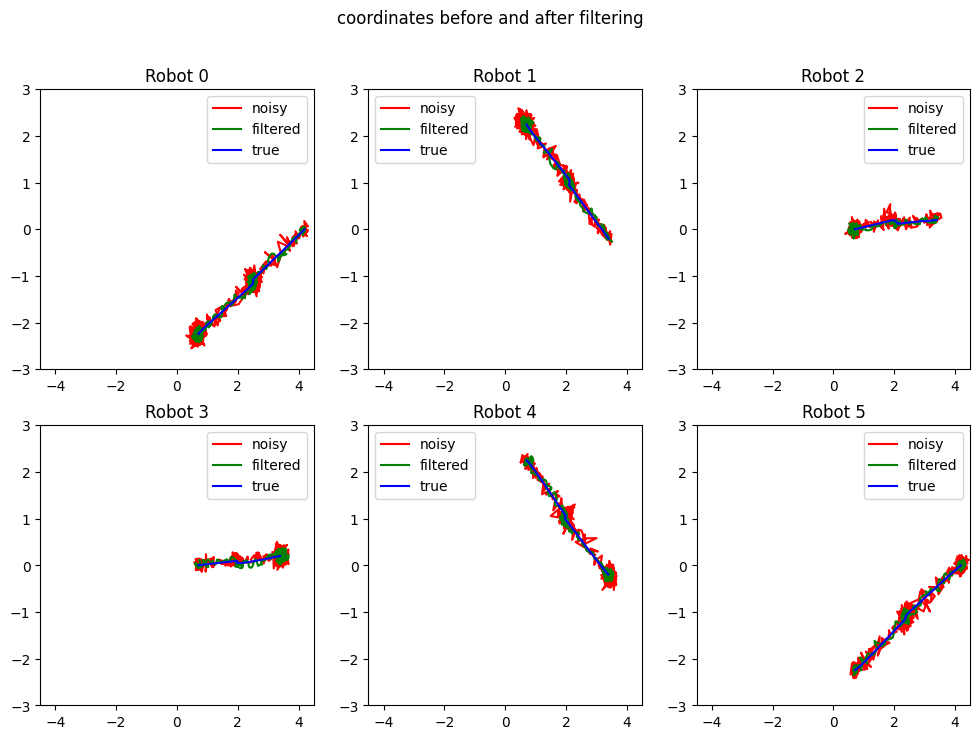

In [70]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("coordinates before and after filtering")

for id in range(NO_ROBOTS):
    clean = extract_robot(CLEAN_FD, id)
    noisy_g, filt_g = extract_robot(NOISY_G_FD, id), extract_robot(FILT_G_FD, id)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.set_xlim(-4.5, 4.5)
    current_ax.set_ylim(-3, 3)
    
    current_ax.plot(noisy_g[X_COL], noisy_g[Y_COL], "r")
    current_ax.plot(filt_g[X_COL], filt_g[Y_COL], "g")
    current_ax.plot(clean[X_COL], clean[Y_COL], "b")
    
    current_ax.legend(("noisy", "filtered", "true"))

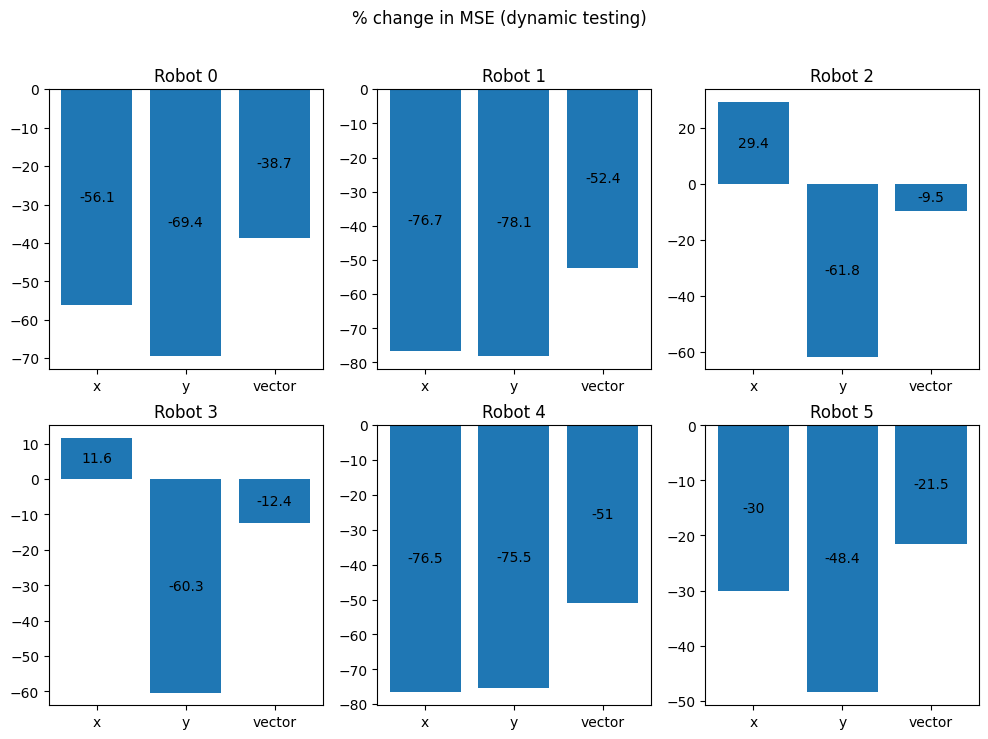

In [71]:
def percentage_diff(
    old: float,
    new: float
) -> float:
    return round((new-old) / old * 100, 1)


def diff_squared(t: float, a: float) -> float:
    return (t - a) ** 2


def mean_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str,
    id: Union[int, None] = None
    ) -> float:
    if id:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
        
    return true_data[param].combine(
            other=actual_data[param],
            func=diff_squared
        ).mean()


def vectorify(x: float, y: float) -> np.ndarray:
    return np.array((x, y))


def mean_squared_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    id: Union[int, None] = None
    ) -> float:
    if id:
        true_data = extract_robot(true_data, id)
        actual_data = extract_robot(actual_data, id)
    
    true_vec = true_data[X_COL].combine(
        other=true_data[Y_COL],
        func=vectorify
    )
    
    actual_vec = actual_data[X_COL].combine(
        other=actual_data[Y_COL],
        func=vectorify
    )
    
    return np.linalg.norm(true_vec - actual_vec).mean()


fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle(f"% change in MSE (dynamic testing)")

for id in range(NO_ROBOTS):
    baseline_x = mean_squared_error(
        CLEAN_FD,
        NOISY_G_FD,
        X_COL,
        id
    )
    
    baseline_y = mean_squared_error(
        CLEAN_FD,
        NOISY_G_FD,
        Y_COL,
        id
    )
    
    baseline_v = mean_squared_error_vec(
        CLEAN_FD,
        NOISY_G_FD,
        id
    )

    error_x = mean_squared_error(
        CLEAN_FD,
        FILT_G_FD,
        X_COL,
        id
    )
    
    error_y = mean_squared_error(
        CLEAN_FD,
        FILT_G_FD,
        Y_COL,
        id
    )
    
    error_v = mean_squared_error_vec(
        CLEAN_FD,
        FILT_G_FD,
        id
    )
    
    delta_x = percentage_diff(baseline_x, error_x)
    delta_y = percentage_diff(baseline_y, error_y)
    delta_v = percentage_diff(baseline_v, error_v)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    bars = current_ax.bar([X_COL, Y_COL, V_COL], [delta_x, delta_y, delta_v])
    current_ax.bar_label(bars, label_type='center')

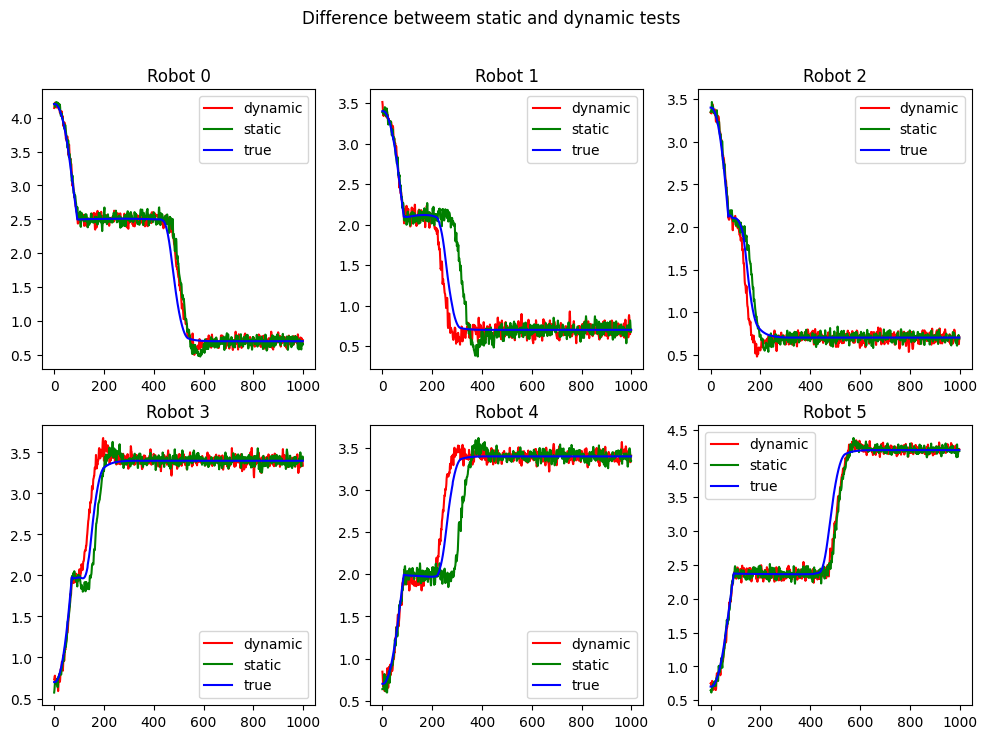

In [72]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle("Difference betweem static and dynamic tests")

for id in range(NO_ROBOTS):
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(X_AXES, extract_robot(FILT_G_FD, id)[X_COL], "r")
    current_ax.plot(X_AXES, pd.read_csv(f"static_filter{id}.csv")[X_COL], "g")
    current_ax.plot(X_AXES, extract_robot(CLEAN_FD, id)[X_COL], "b")
    
    current_ax.legend(("dynamic", "static", "true"))

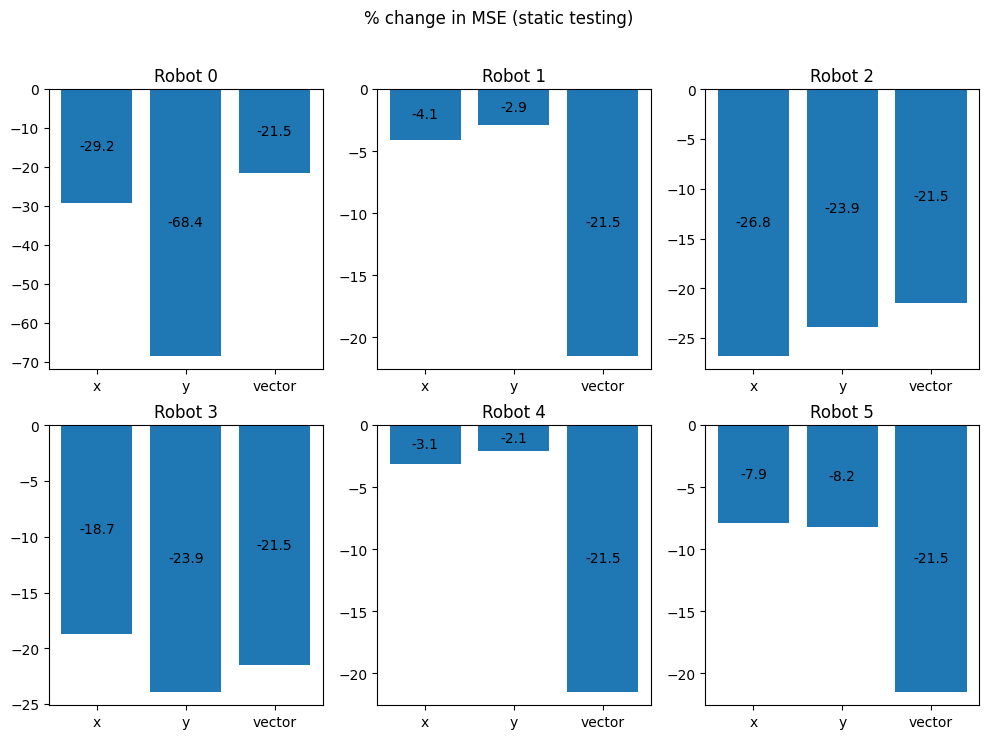

In [73]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle(f"% change in MSE (static testing)")

for id in range(NO_ROBOTS):
    static_filter = format_data(f"static_filter{id}.csv", False)
    clean = extract_robot(CLEAN_FD, id)

    baseline_x = mean_squared_error(
        CLEAN_FD,
        NOISY_G_FD,
        X_COL,
        id
    )
    
    baseline_y = mean_squared_error(
        CLEAN_FD,
        NOISY_G_FD,
        Y_COL,
        id
    )
    
    baseline_v = mean_squared_error_vec(
        CLEAN_FD,
        NOISY_G_FD,
        id
    )

    error_x = mean_squared_error(
        clean,
        static_filter,
        X_COL
    )
    
    error_y = mean_squared_error(
        clean,
        static_filter,
        Y_COL
    )
    
    error_v = mean_squared_error_vec(
        clean,
        static_filter
    )
    
    delta_x = percentage_diff(baseline_x, error_x)
    delta_y = percentage_diff(baseline_y, error_y)
    delta_y = percentage_diff(baseline_v, error_v)
    
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    bars = current_ax.bar([X_COL, Y_COL, V_COL], [delta_x, delta_y, delta_v])
    current_ax.bar_label(bars, label_type='center')

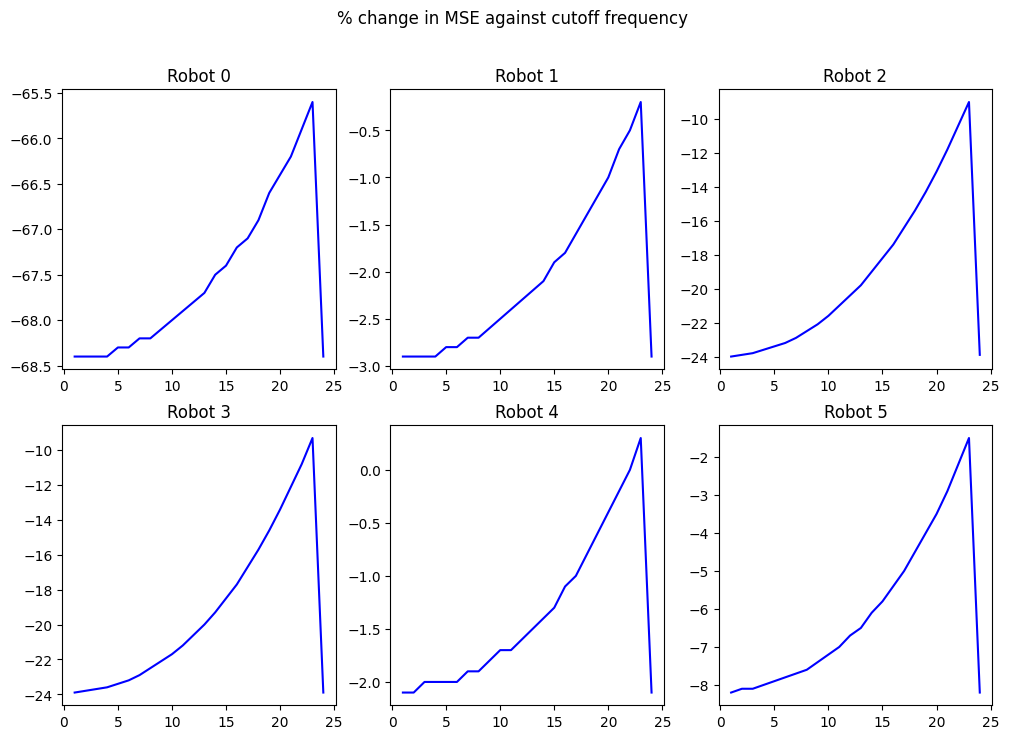

In [76]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle(f"% change in MSE against cutoff frequency")

CUTOFFS = list(range(1, 25))

for id in range(NO_ROBOTS):
    delta_v = []

    baseline_v = mean_squared_error_vec(
        CLEAN_FD,
        NOISY_G_FD,
        id
    )

    for c in CUTOFFS:
        filter = FIR_filter(cutoff=c)
        
        clean = extract_robot(CLEAN_FD, id)
        noisy = extract_robot(NOISY_G_FD, id)
        filtered = pd.DataFrame(columns=COLS)
        
        for (_, entry) in noisy.iterrows():
            (x_f, y_f, th_f) = filter.step([
                entry[X_COL],
                entry[Y_COL],
                entry[TH_COL]
            ])
            
            new_row = pd.DataFrame(
                {
                    X_COL: x_f,
                    Y_COL: y_f,
                    TH_COL: th_f
                },
                index=[0]
            )
            
            filtered = pd.concat([filtered, new_row], ignore_index=True)
        
        filtered = filtered.reset_index(drop=True)

        error_v = mean_squared_error_vec(
            clean,
            filtered
        )

        delta_v.append(percentage_diff(baseline_v, error_v))
        
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(CUTOFFS, delta_v, "b")

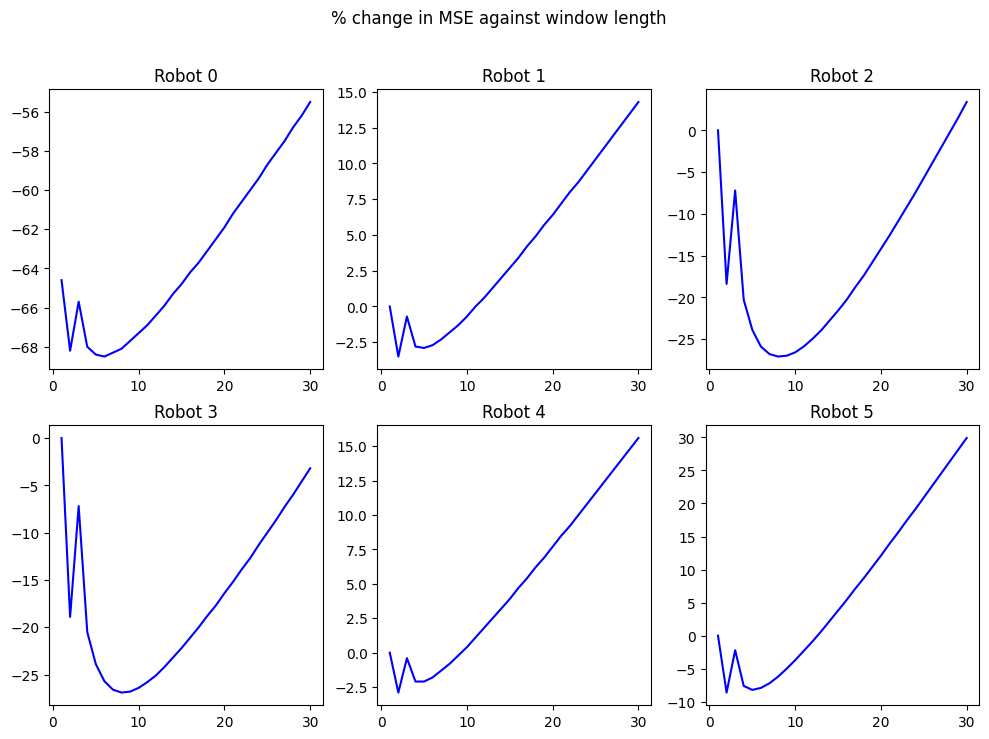

In [78]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(12,8)
fig.suptitle(f"% change in MSE against window length")

WINDOWS = list(range(1, 31))

for id in range(NO_ROBOTS):
    delta_v = []

    baseline_v = mean_squared_error_vec(
        CLEAN_FD,
        NOISY_G_FD,
        id
    )

    for w in WINDOWS:
        filter = FIR_filter(window_len=w)
        
        clean = extract_robot(CLEAN_FD, id)
        noisy = extract_robot(NOISY_G_FD, id)
        filtered = pd.DataFrame(columns=COLS)
        
        for (_, entry) in noisy.iterrows():
            (x_f, y_f, th_f) = filter.step([
                entry[X_COL],
                entry[Y_COL],
                entry[TH_COL]
            ])
            
            new_row = pd.DataFrame(
                {
                    X_COL: x_f,
                    Y_COL: y_f,
                    TH_COL: th_f
                },
                index=[0]
            )
            
            filtered = pd.concat([filtered, new_row], ignore_index=True)
        
        filtered = filtered.reset_index(drop=True)

        error_v = mean_squared_error_vec(
            clean,
            filtered
        )

        delta_v.append(percentage_diff(baseline_v, error_v))
        
    current_ax = get_current_ax(axs, id)
    current_ax.set_title(f"Robot {id}")
    current_ax.plot(WINDOWS, delta_v, "b")